# Q1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import pickle
from io import BytesIO
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

### a

In [2]:
# Load the image using PIL
img = Image.open("Cliff_beach_BOEM_gov.jpg")

In [3]:
# Convert the image to a numpy array
img_arr = np.array(img)

# Get the dimensions of the image
width, height, colour  = img_arr.shape
print("Image width: {}, height: {}, that is number of pixels. And for each pixel we have {} colours (RGB).".format(width, height, colour))

Image width: 1830, height: 2746, that is number of pixels. And for each pixel we have 3 colours (RGB).


Width and height value are the number of pixels. The value of the 3rd dimension is the colour from RGB method (0-255,0-255,0-255).

### b

In [4]:
img_arr_sum = img_arr.sum(axis=2)

In [5]:
# Normalize the image by subtracting the mean and dividing by the standard deviation
img_arr_normalized = (img_arr_sum - np.mean(img_arr_sum)) / np.std(img_arr_sum)


Plot the original and normalized images side by side:

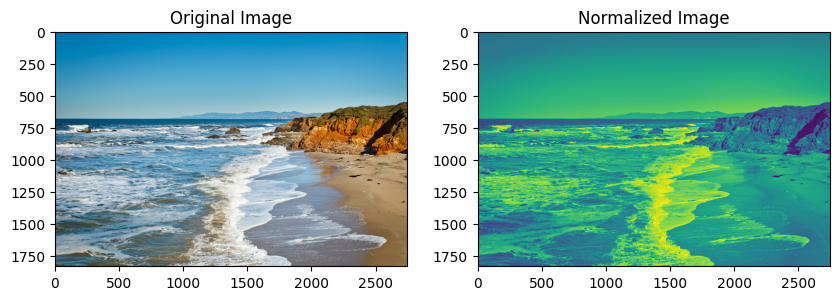

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_arr)
ax1.set_title("Original Image")
ax2.imshow(img_arr_normalized)
ax2.set_title("Normalized Image")
plt.show()

<br> We got the negative of the picture that we had before. The normalization process reduced the overall contrast of the image

In [7]:
# Save the Original image in memory using BytesIO
img_bytes = BytesIO()
img.save(img_bytes, format='JPEG')
# Check the size of the image in bytes
size_in_bytes = img_bytes.tell()
print("Size of the Original image in bytes:", size_in_bytes)

Size of the Original image in bytes: 675682


In [8]:
# Revert normalized image into uint8 type
img_arr_img_norm = Image.fromarray(img_arr_normalized.astype(np.uint8))
# Save the Normalized image in memory using BytesIO
img_bytes1 = BytesIO()
img_arr_img_norm.save(img_bytes, format='JPEG')
# Check the size of the image in bytes
size_in_bytes = img_bytes.tell()
print("Size of the Normalized image in bytes:", size_in_bytes)

Size of the Normalized image in bytes: 1400311


### c

In [9]:
# Perform SVD decomposition and obtain the singular values
U, s, Vt = np.linalg.svd(img_arr_normalized)
print("Number of singular values is:", len(s))

Number of singular values is: 1830


We have exactly this number of singular values due the fact that 1830 is the width of our picture that is dim of the matrix

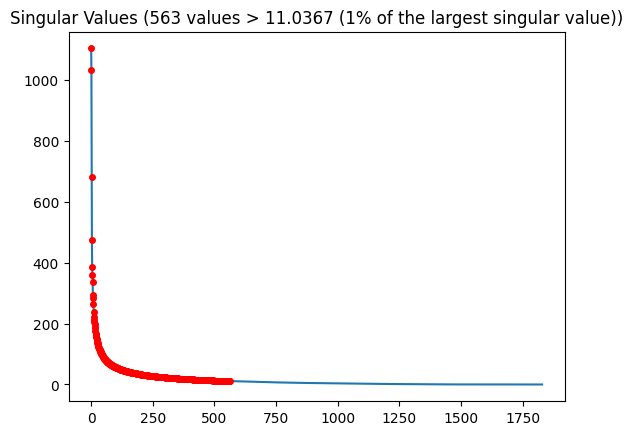

In [10]:
# Plot the singular values and the threshold
threshold = 0.01 * s[0] # 1% of the largest singular value
num_singular_values = np.sum((s > threshold))
plt.plot(s)
plt.plot(s[s > threshold], 'ro', markersize=4)
plt.title(f"Singular Values ({num_singular_values} values > {threshold:.4f} (1% of the largest singular value))")
plt.show()

### d

Reconstructed Image Size with 12 PCs: 248213 bytes
Reconstructed Image Size with 24 PCs: 337995 bytes
Reconstructed Image Size with 48 PCs: 439669 bytes
Reconstructed Image Size with 96 PCs: 553668 bytes
Reconstructed Image Size with 563 PCs: 728039 bytes


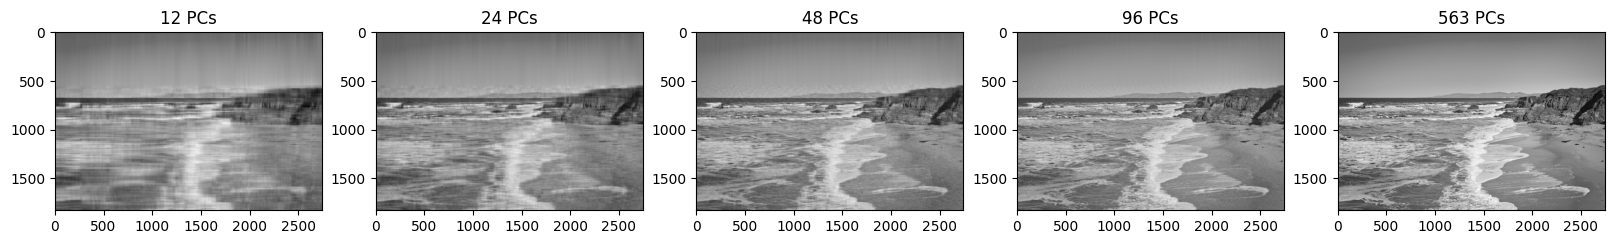

In [11]:
pcs = [12, 24, 48, 96, len(s[s > threshold])]

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i, num_pc in enumerate(pcs):
# Calculate the number of principal components required to obtain the desired number of PCs
    img_reconstructed = U[:, :num_pc] @ np.diag(s[:num_pc]) @ Vt[:num_pc, :]
    # Display the reconstructed image
    axs[i].imshow(img_reconstructed, cmap='gray')
    axs[i].set_title(f"{num_pc} PCs")
    # Calculate the size of the final reconstruction
    img_bytes = BytesIO()
    img_reconstructed_pic= Image.fromarray(img_reconstructed.astype(np.uint8))
    img_reconstructed_pic.save(img_bytes, format='JPEG')
    # Check the size of the image in bytes
    size = img_bytes.tell()
    print(f"Reconstructed Image Size with {num_pc} PCs: {size} bytes")
plt.show()


<br> First of all, we have used gray pictures (cmap='gray') because much easier to recognize the difference between pictures with different PC's with b&w than negative one.
<br> So what we can conclude from the pictures?
When we are reducing the number of PC's from 563 to 96 there is no big difference between pictures that means that first 96 PC's explain the most of the variance in the given normalized picture that is great evidence why we need PCA algorithm. But if we take a look on 12 PC's picture we would see clear difference with the full picture that means that 12 PC's is not enough for the good picture, but still we can see approximately what is on the picture that is good but not enough for us if we want to downgrade the number of PC's with minimum influence on the quality, but may be good for other purposes. <br>
Also important to add that on the graph of singular values we've seen that first of them have much higher values than others that means that they explain most of the variance of the picture colours.

<br> There is a correlation between the decreasing value of the PCs and the decreasing image size, indicating that as the value of the PCs decreases, the image size tends to decrease as well.

# Q2

### A
Load the files:

In [12]:
with open("exodus_pickled", "rb") as f:
    exodus_pickled = pickle.load(f)

features = np.loadtxt("features.txt", delimiter="\t", dtype="str")[:-1] # cause the last feature is empty string ('')
labels = np.loadtxt("labels.txt")

print(f"Features dimension: {features.shape[0]}")
print(f"Labels dimension: {labels.shape[0]}")
print(f"Matrix dimensions: {exodus_pickled.shape}")

Features dimension: 15373
Labels dimension: 1201
Matrix dimensions: (1201, 15373)


| The features is the array that lists the unique triplets of words associated with each column of exodus_pickled. The labels array contains the hypothetical association of each verse to one of two groups: 0 (non-priestly) or 1 (priestly).<br>
 The number of raws in **exodus_pickled** is exactly the number of the psukim (where each one of them has a lable), and the number of columns is the number of the triple words included in the Shemot, which are our *features*.

### B

In their current format, it's difficult to make a plot of the verses and check whether the association with the groups shows a real difference between them. This is because the data is high-dimensional, making it challenging to visualize the relationship between the priestly and non-priestly schools directly. We need to perform dimensionality reduction first.

### C

SVD decomposition on the exodus_pickled matrix:

In [13]:
U, s, Vt = np.linalg.svd(exodus_pickled)

In [14]:
print(f"U dimensions: {U.shape}")
print(f"s dimension: {s.shape[0]}")
print(f"Vt dimensions: {Vt.shape}")

U dimensions: (1201, 1201)
s dimension: 1201
Vt dimensions: (15373, 15373)


The dimensions of the three components are:

*U*: The columns are the left singular vectors, which form an orthonormal basis for the column space of the input matrix.
*s*: These diagonal elements are the singular values in descending order (it is a 1-dimensional array here)
*Vt*: The rows are the right singular vectors, which form an orthonormal basis for the row space of the input matrix.Number of unique triplets of words in Sefer Shemot<br>

The matrix **Vt** expresses the importance vectors of each three words for each PC because its dimensions match the dimensions of the features.

### D

Finding the top 10 absolute loading values for the first PC:

In [52]:
top_loading_indices = np.argsort(-np.abs(pd.DataFrame(Vt.T).iloc[:,0])) # Using V transposed to return the most valuable triples
top_triple_words = features[top_loading_indices]
top_triple_words[:10]

array(["('ו', 'עשׂה', 'את')", "('עשׂה', 'את', 'ה')", "('ו', 'צפה', 'את')",
       "('ו', 'את', 'ה')", "('אמה', 'ו', 'חצי')", "('ו', 'נתן', 'את')",
       "('ה', 'אחד', 'ו')", "('צפה', 'את', 'זהב')", "('ו', 'עשׂה', 'ל')",
       "('תכלת', 'ו', 'ארגמן')"], dtype='<U29')

The commonality between these ten triplets of words and their importance for the first PC might suggest a specific theme or pattern that differentiates the priestly and non-priestly schools.

<br> Most of the ten triplets of words include the name of God , indicating that the frequency of these words is important for distinguishing between the priestly and non-priestly schools. The importance of these ten triplets of words for the first PC suggests that the first PC primarily distinguishes between verses that mention God frequently (priestly) and those that do not (non-priestly).

### E


### F
Projecting the data on the first two PCs and display them graphically:

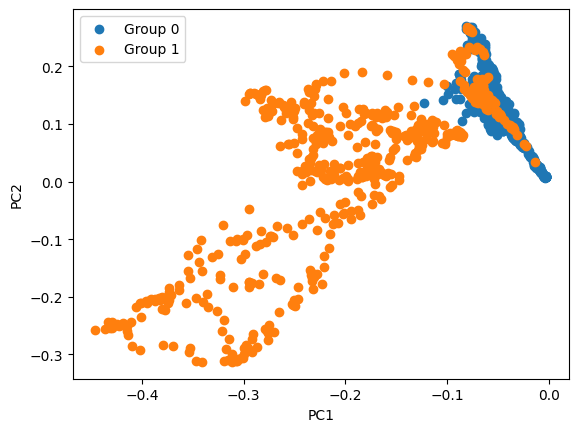

In [16]:
# Projecting the data
projected_data = exodus_pickled @ Vt[:2, :].T



group0_x, group0_y = [], []
group1_x, group1_y = [], []

for i in range(len(labels)):
    if labels[i] == 0:
        group0_x.append(projected_data[i, 0])
        group0_y.append(projected_data[i, 1])
    elif labels[i] == 1:
        group1_x.append(projected_data[i, 0])
        group1_y.append(projected_data[i, 1])

plt.scatter(group0_x, group0_y, label="Group 0")
plt.scatter(group1_x, group1_y, label="Group 1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()
